In [1]:
cd TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from TileEM_plot_toolbox import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd output

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/output


In [4]:
# os.chdir("../../")
# visualize_bb_objects(objid,worker_id=146)
# os.chdir("TileEM/output")

In [5]:
def PR_compare(objid):
    worker_ids,worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid,return_worker_id=True)
    #best recall based workers 
#     best_worker = list(set((np.argmax(worker_recall_lst),np.argmax(worker_precision_lst))))[0]
    best_worker =  np.argmax(worker_recall_lst)
    print "Best worker's PR against BBG: ", max(worker_precision_lst),max(worker_recall_lst)
    os.chdir("..")
    tiles,indicatorMat= createObjIndicatorMatrix(objid,PRINT=True)
    os.chdir(DATA_DIR)
    approved_tiles = np.where(indicatorMat[best_worker]==1)[0]
    for tidx in approved_tiles:
        plot_coords(Polygon(tiles[tidx]),color="lime")
    
    bb_objects = bb_info[bb_info["object_id"]==objid]
    best_worker_id = worker_ids[best_worker]
    print best_worker_id
    worker_bb_info = bb_objects[bb_objects["worker_id"]==best_worker_id]
    worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))#.buffer(0)

    plot_coords(worker_BB_polygon,color='#0000ff',reverse_xy=True)
    
    joined_bb = join_tiles(approved_tiles,tiles)
    joined_p, joined_r = compute_PR(objid,approved_tiles,tiles)
    print "Joined PR:",joined_p, joined_r
    diff_r = max(worker_recall_lst)-joined_r
    diff_p = max(worker_precision_lst)-joined_p
    print "Difference: ", diff_p,diff_r
    return diff_p,diff_r

# Eliminating Self-crossing BBs 

In [60]:
cd crowd-seg/analysis/TileEM/output/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/output


Best worker's PR against BBG:  0.938146640755 1.0
Number of non-overlapping tile regions (M) :  374
Number of workers (N) :  40
all unvoted tiles: [  0  12  31  63 134]
all unvoted workers: []
Deleting  5 tiles:  [  0  12  31  63 134]
13.42
106.22
1.42
14.42
9.62
Object  41
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
114
Joined PR: 0.885802771092 0.558211725887
Difference:  0.0523438696628 0.441788274113


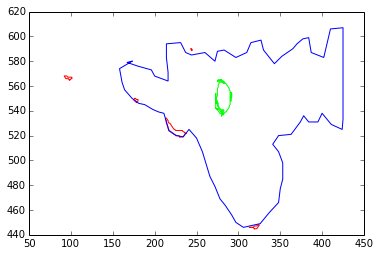

In [61]:
objid=41
worker_ids,worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid,return_worker_id=True)
#best recall based workers 
#     best_worker = list(set((np.argmax(worker_recall_lst),np.argmax(worker_precision_lst))))[0]
best_worker =  np.argmax(worker_recall_lst)
print "Best worker's PR against BBG: ", max(worker_precision_lst),max(worker_recall_lst)
os.chdir("..")
tiles,indicatorMat= createObjIndicatorMatrix(objid,PRINT=True)
os.chdir(DATA_DIR)
approved_tiles = np.where(indicatorMat[best_worker]==1)[0]
for tidx in approved_tiles:
    plot_coords(Polygon(tiles[tidx]),color="lime")

bb_objects = bb_info[bb_info["object_id"]==objid]
best_worker_id = worker_ids[best_worker]
print best_worker_id
worker_bb_info = bb_objects[bb_objects["worker_id"]==best_worker_id]
worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))#.buffer(0)

plot_coords(worker_BB_polygon,color='#0000ff',reverse_xy=True)

joined_bb = join_tiles(approved_tiles,tiles)
joined_p, joined_r = compute_PR(objid,approved_tiles,tiles)
print "Joined PR:",joined_p, joined_r
diff_r = max(worker_recall_lst)-joined_r
diff_p = max(worker_precision_lst)-joined_p
print "Difference: ", diff_p,diff_r


ERROR:shapely.geos:TopologyException: Input geom 0 is invalid: Self-intersection at or near point 169.21951219512195 578.48780487804879 at 169.21951219512195 578.48780487804879


Tile 0
0.0


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x10b3d0d10>

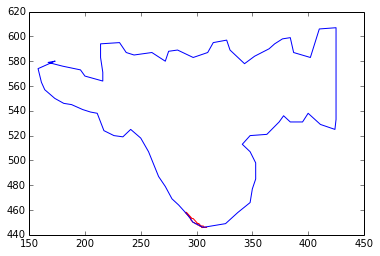

In [14]:
for tile_i in [  0 , 12,  31 , 63 ,134]: 
    plt.figure()
    tile= Polygon(tiles[tile_i]).buffer(0)
    plot_coords(tile)
    plot_coords(worker_BB_polygon,color='#0000ff',reverse_xy=True)
    print "Tile",tile_i
    print tile.intersection(worker_BB_polygon.buffer(0)).area
    print worker_BB_polygon.intersection(tile).area
    print float(tile.area)
    print tile.area

Best worker's PR against BBG:  0.938146640755 1.0
Number of non-overlapping tile regions (M) :  374
Number of workers (N) :  40
all unvoted tiles: [  0  12  31  63 134]
all unvoted workers: []
Deleting  5 tiles:  [  0  12  31  63 134]
13.42
106.22
1.42
14.42
9.62
Object  41
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
114
Joined PR: 0.885802771092 0.558211725887
Difference:  0.0523438696628 0.441788274113


(0.052343869662767828, 0.4417882741133744)

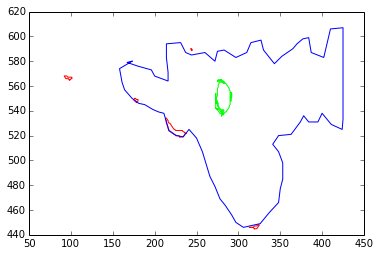

In [9]:
PR_compare(41)

In [62]:
from shapely.validation import explain_validity
print(explain_validity(worker_BB_polygon))

Self-intersection[169.219512195122 578.487804878049]


In [20]:
explain_validity(worker_BB_polygon).split("[")[0]=='Self-intersection'

True

In [17]:
explain_validity(tile)

'Valid Geometry'

The intersection function fails when the polygon is self intersection [according to this](https://github.com/Toblerity/Shapely/issues/344), this function is used for doing the overlap calculation os this is why for these bounding boxes some of the intersection area is like 0 even though the overlap is clearly very evident. So I need to do preprocessing to eliminate the worker bounding boxes that are self crossing (this is actually allowable in our interface) . I used a very loose constraint of is_close and is_valid, but there are actually many ways that a polygon object can be invalid. To narrow the selection down, I searched for only the self-intersecting bounding box. The self-intersecting bounding box comprise of 6% of our data.

In [29]:
count/float(len(bb_info))

0.06111967128916281

In [55]:
mpld3.disable_notebook()

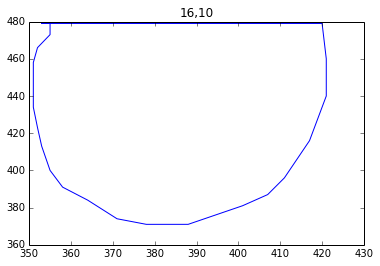

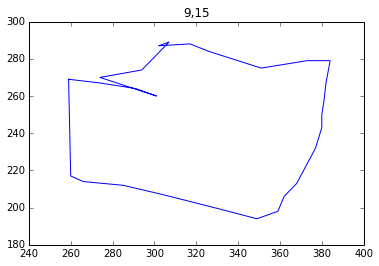

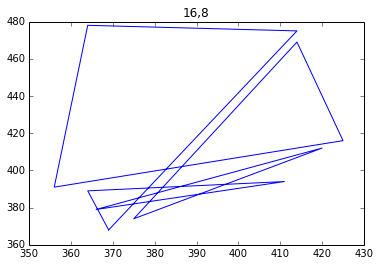

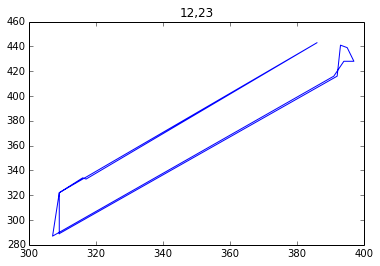

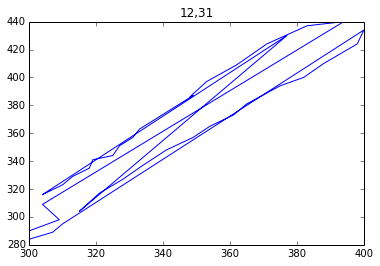

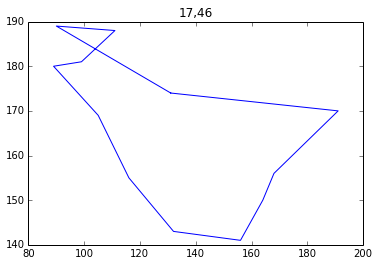

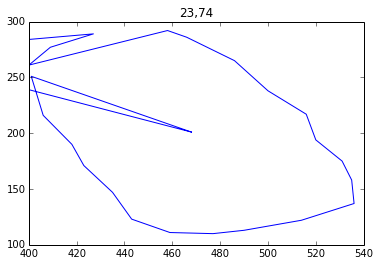

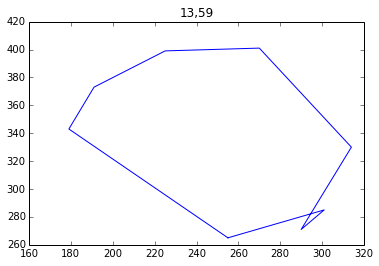

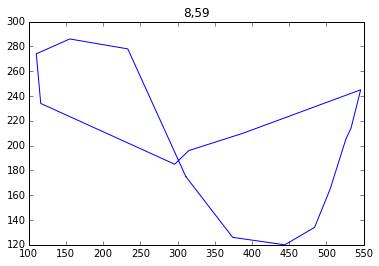

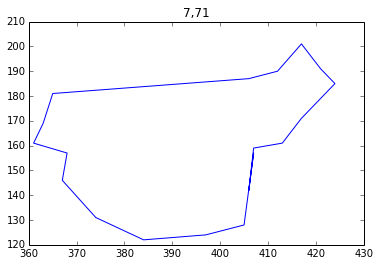

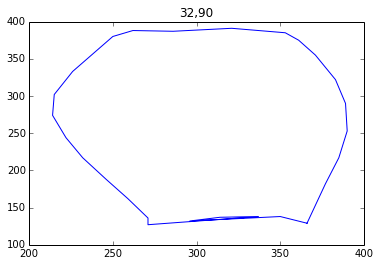

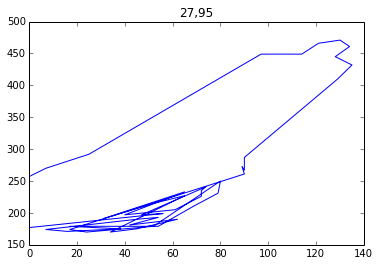

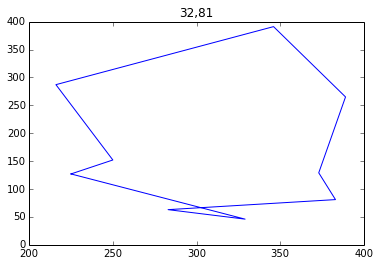

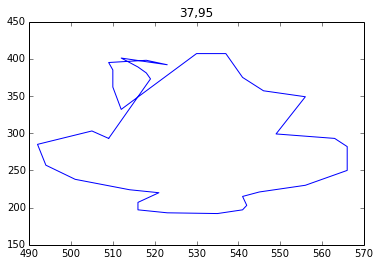

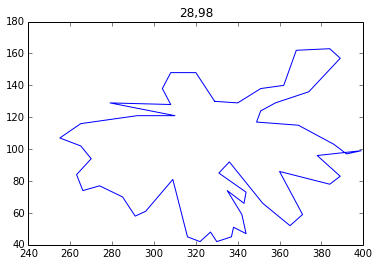

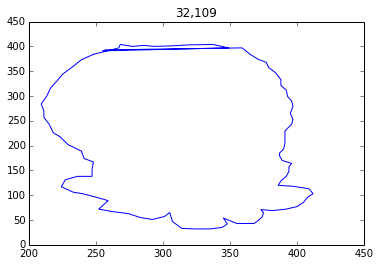

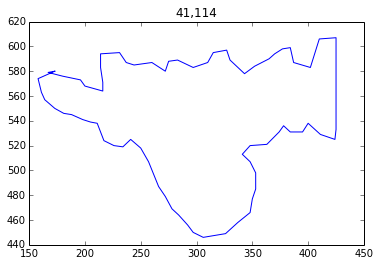

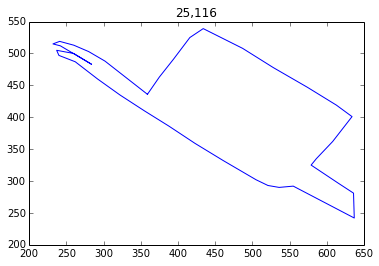

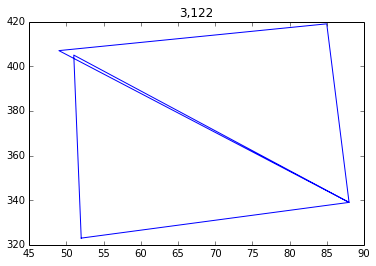

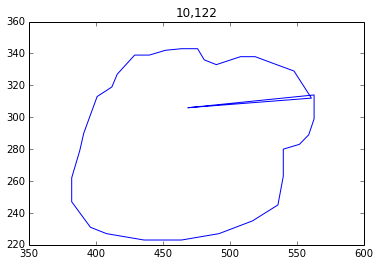

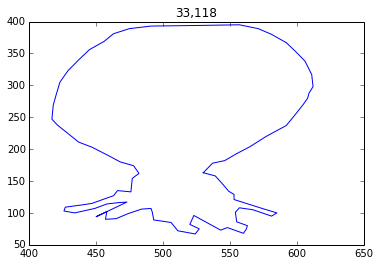

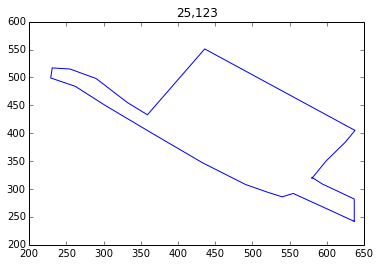

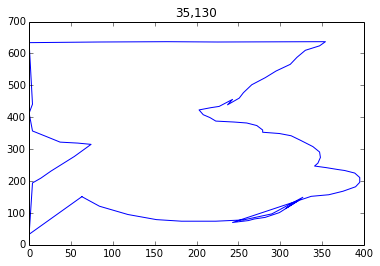

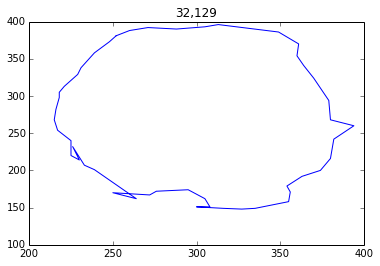

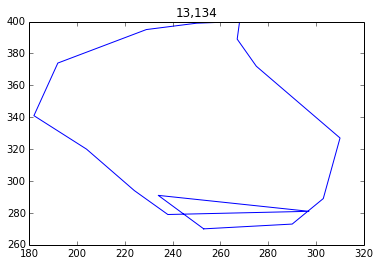

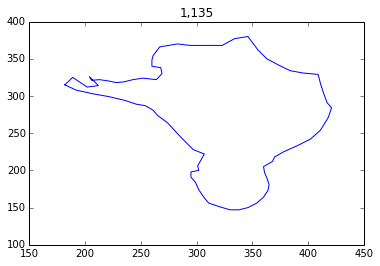

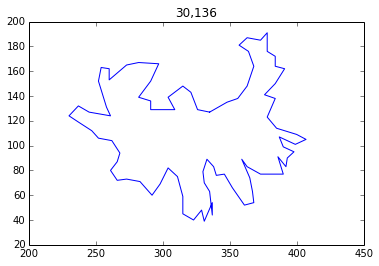

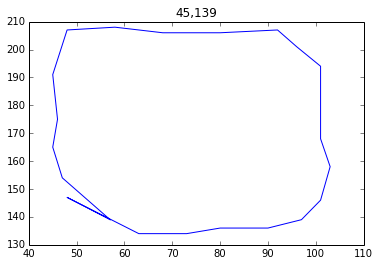

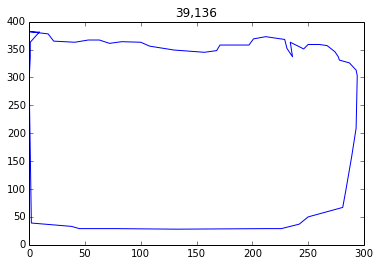

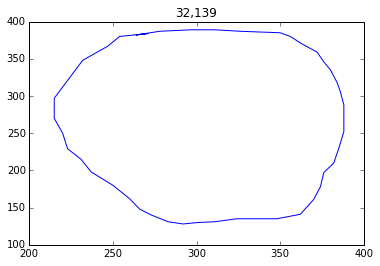

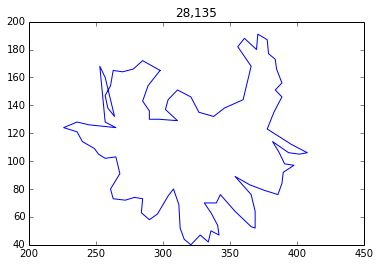

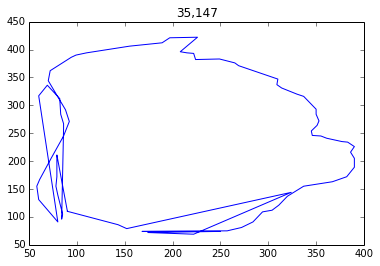

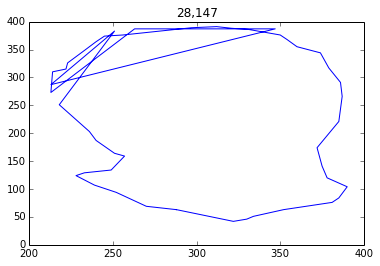

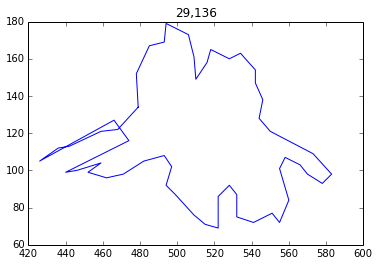

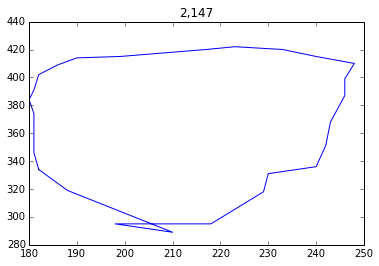

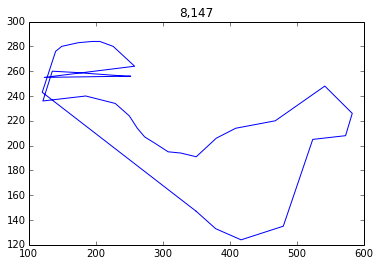

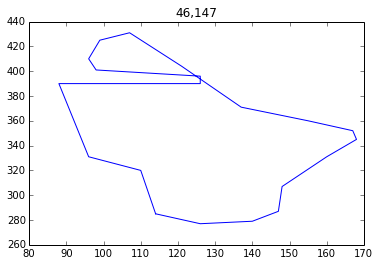

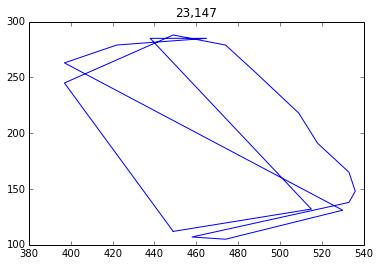

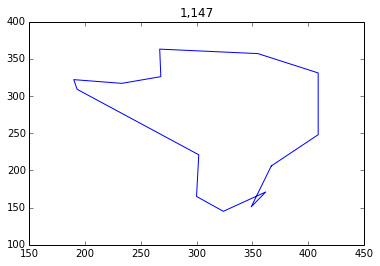

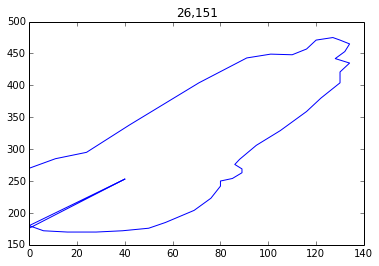

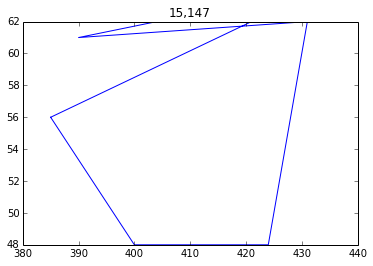

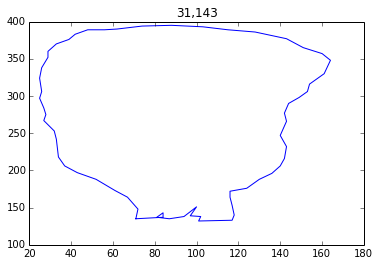

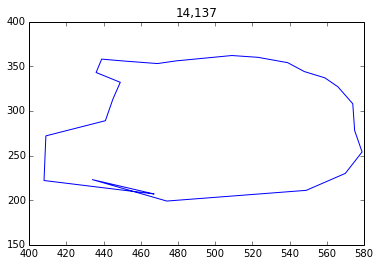

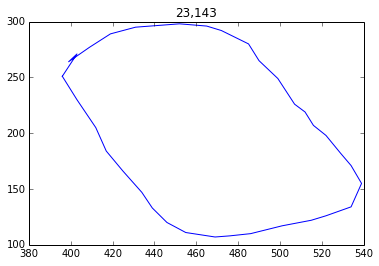

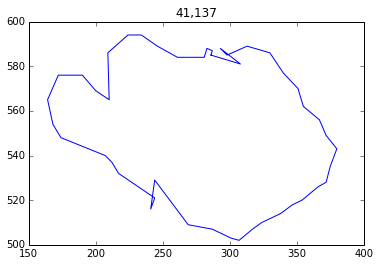

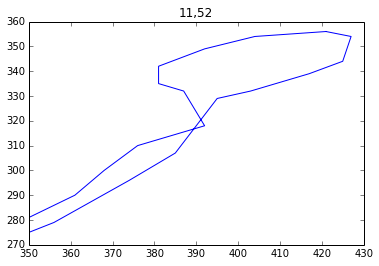

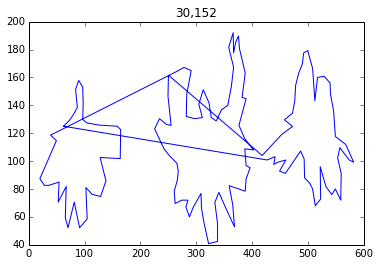

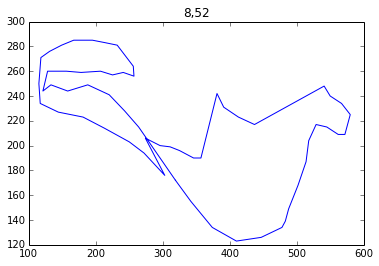

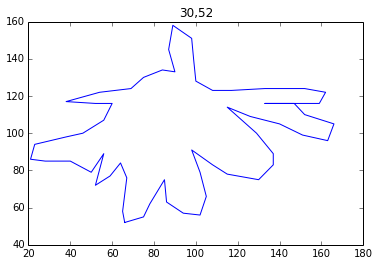

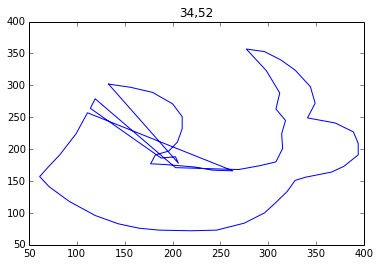

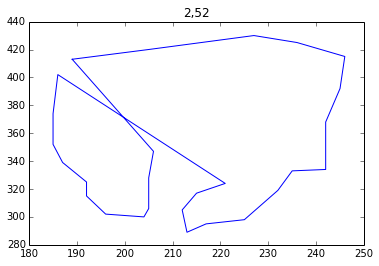

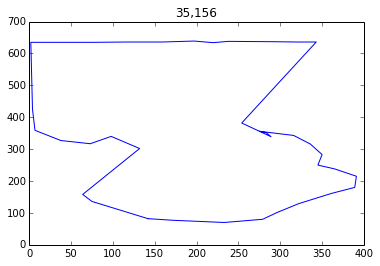

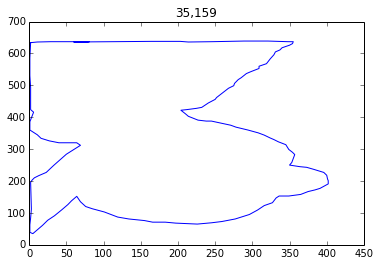

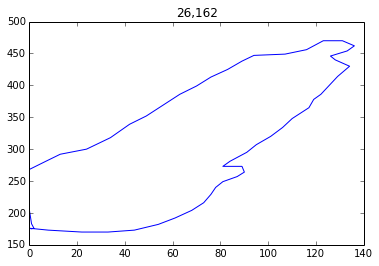

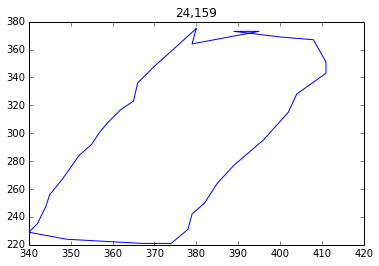

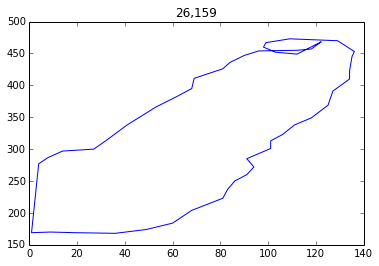

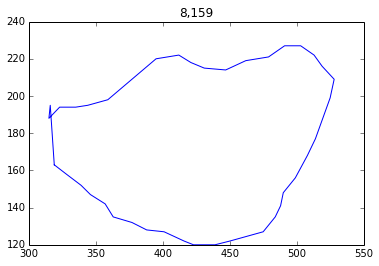

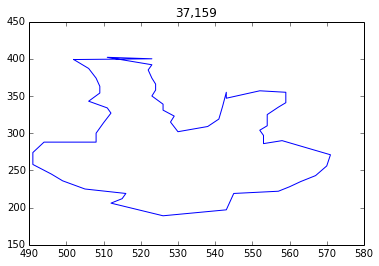

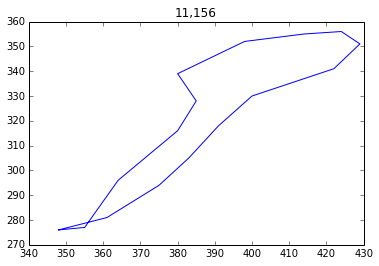

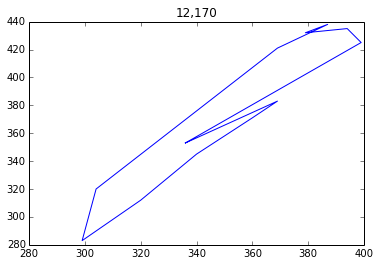

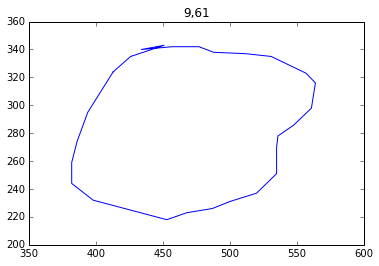

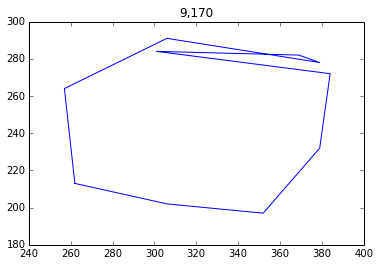

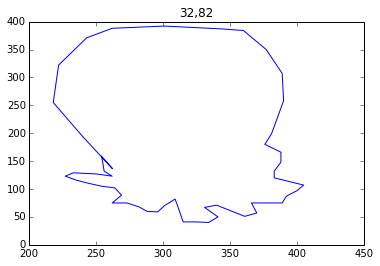

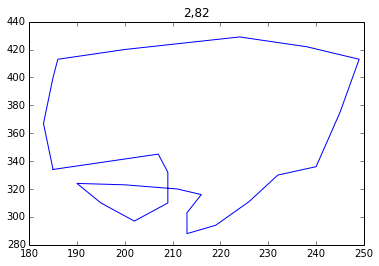

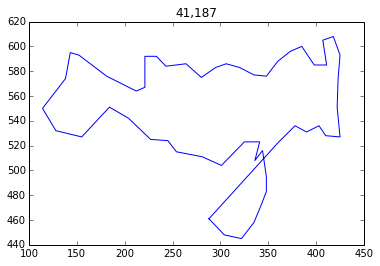

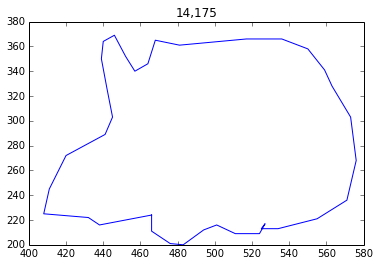

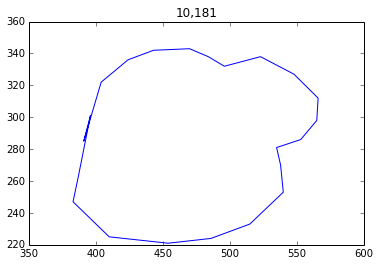

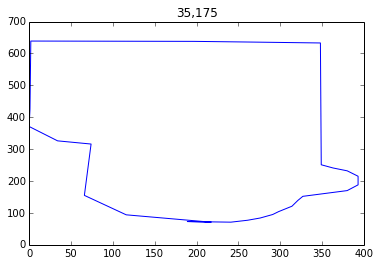

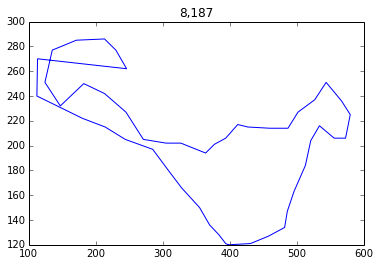

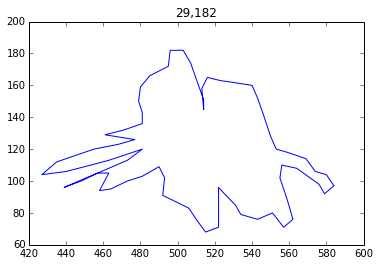

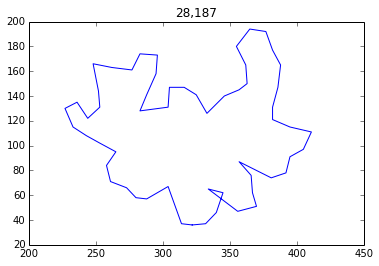

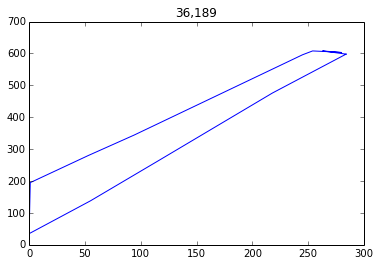

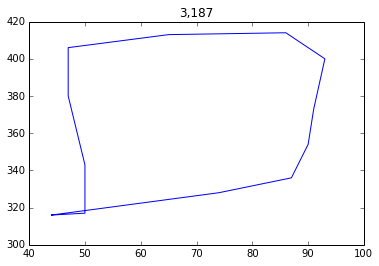

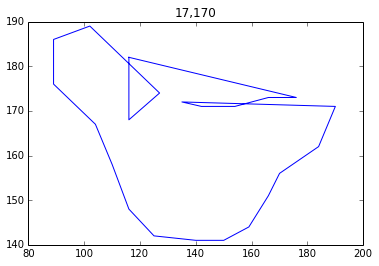

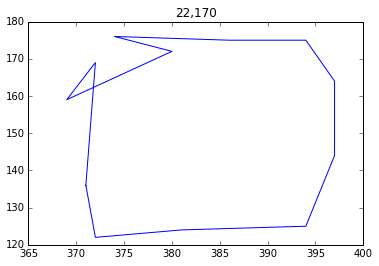

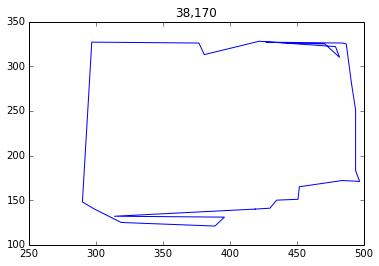

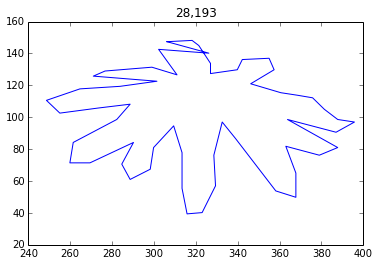

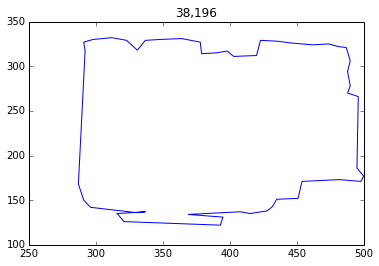

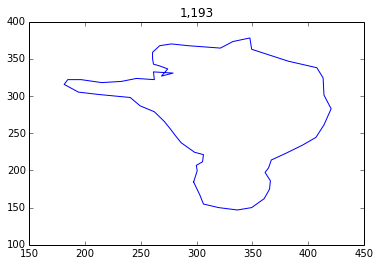

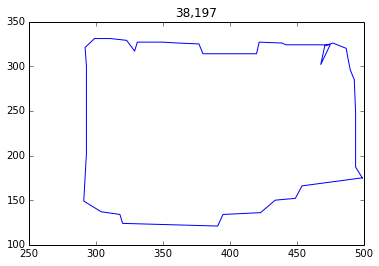

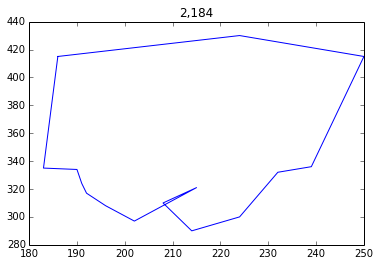

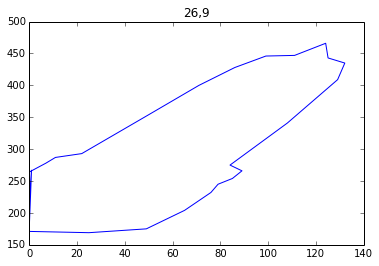

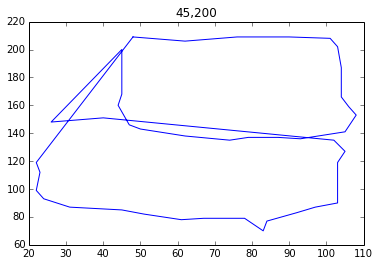

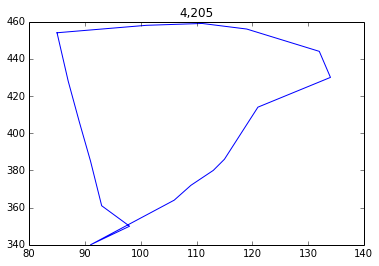

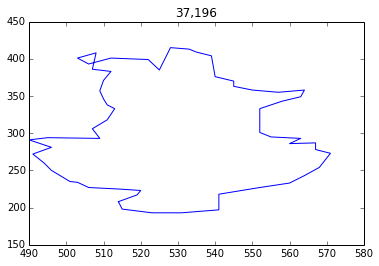

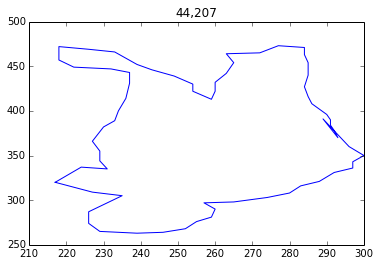

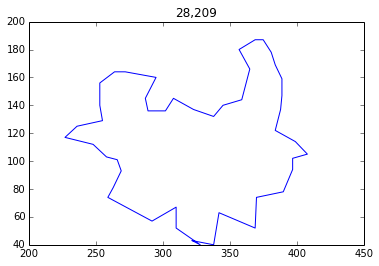

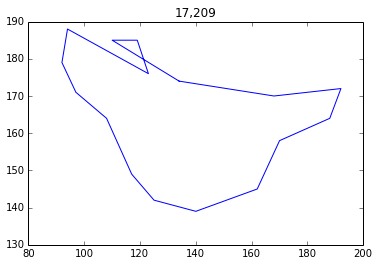

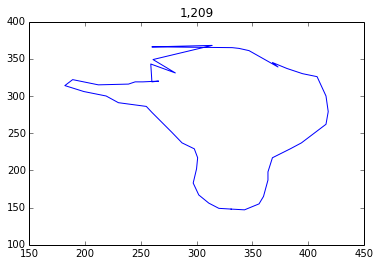

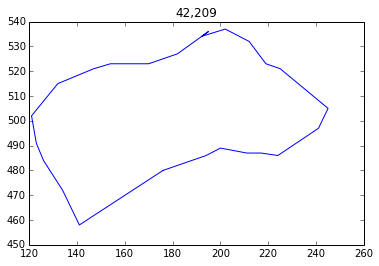

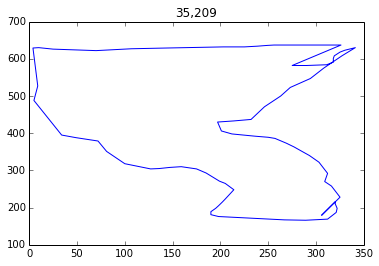

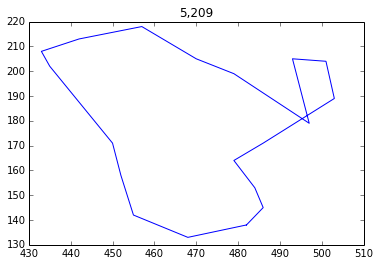

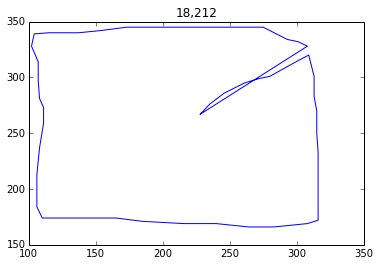

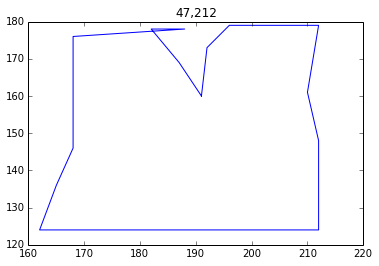

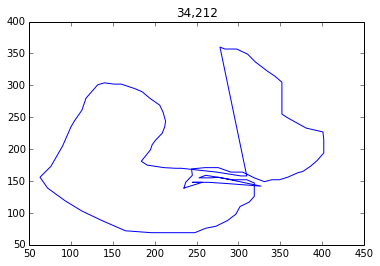

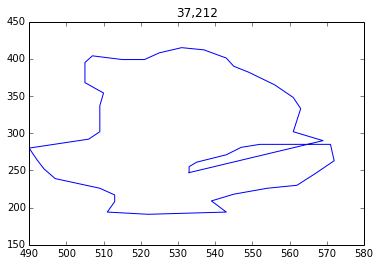

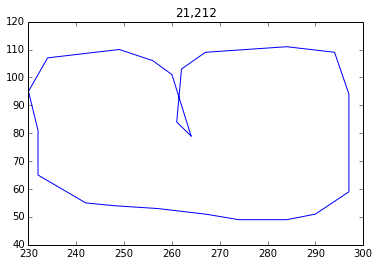

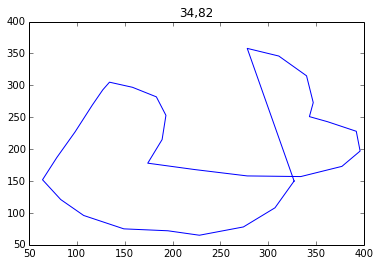

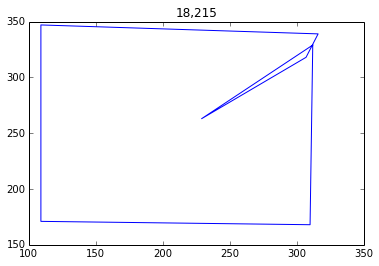

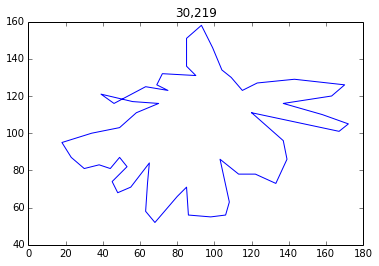

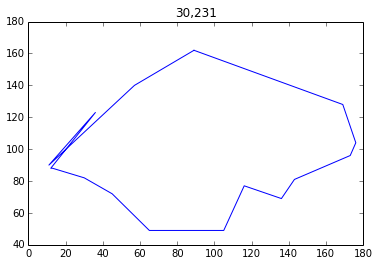

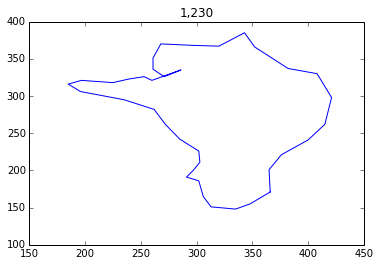

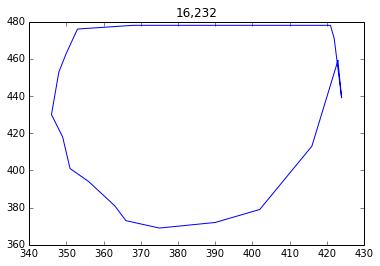

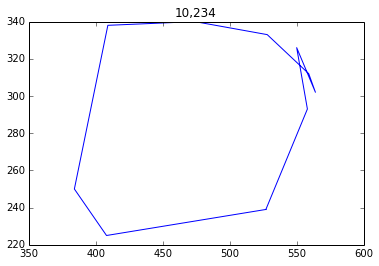

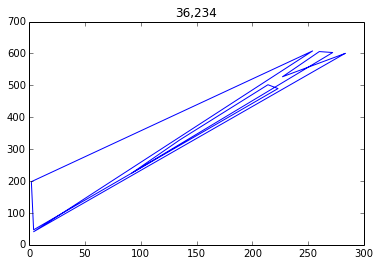

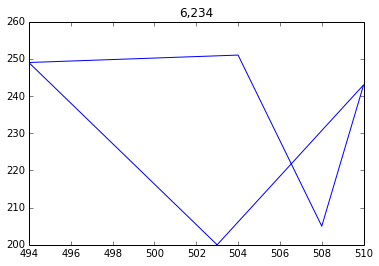

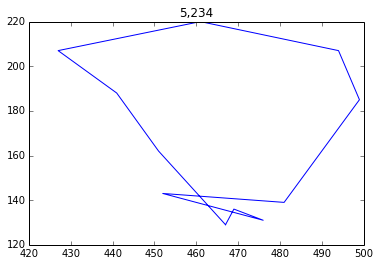

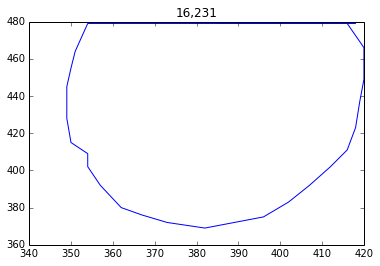

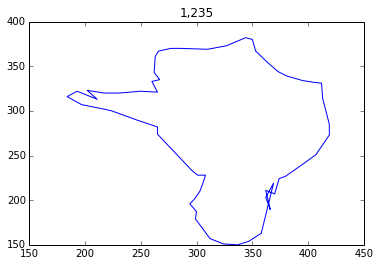

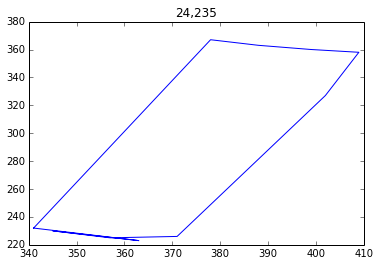

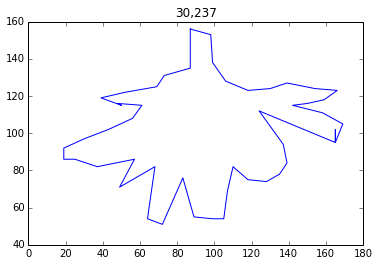

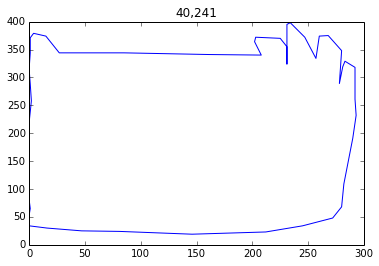

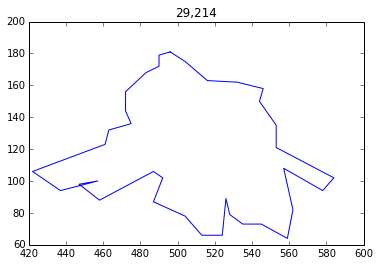

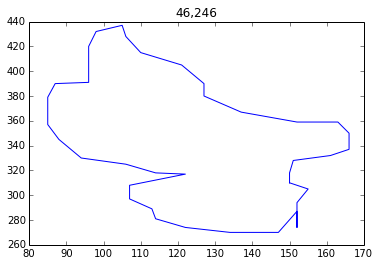

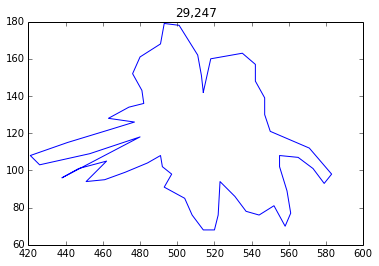

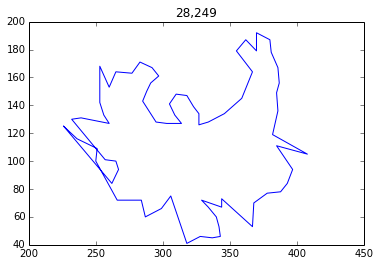

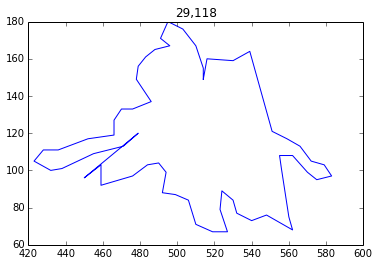

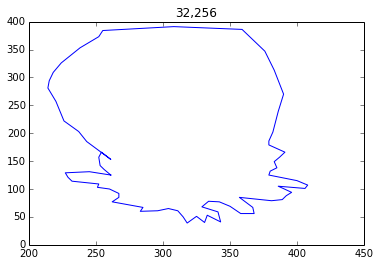

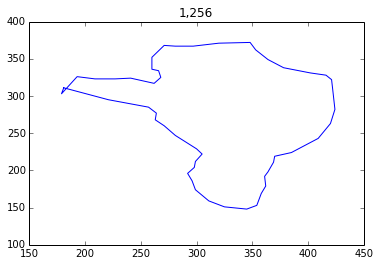

In [65]:
img_info,object_tbl,bb_info,hit_info=load_info(eliminate_self_intersection_bb=False)
count =0
for bb in tqdm(bb_info.iterrows()):
    bb=bb[1]
    xloc,yloc =  process_raw_locs([bb["x_locs"],bb["y_locs"]]) 
    worker_BB_polygon=Polygon(zip(xloc,yloc))
    #if not (worker_BB_polygon.is_closed and worker_BB_polygon.is_valid):
    if explain_validity(worker_BB_polygon).split("[")[0]=='Self-intersection':
        plt.figure()
        plt.title("{0},{1}".format(bb["object_id"],bb["worker_id"]))
        plt.plot(xloc,yloc,'-',color='blue',linewidth=1)
        count+=1

In [49]:
img_info,object_tbl,bb_info,hit_info=load_info()
print len(bb_info)

1947


In [50]:
for bb in bb_info.iterrows():
    bb=bb[1]
    xloc,yloc =  process_raw_locs([bb["x_locs"],bb["y_locs"]]) 
    worker_BB_polygon=Polygon(zip(xloc,yloc))
    if explain_validity(worker_BB_polygon).split("[")[0]=='Self-intersection':
        bb_info.drop(bb.name, inplace=True)

In [51]:
len(bb_info)

1828

In [52]:
count =0
for bb in tqdm(bb_info.iterrows()):
    bb=bb[1]
    xloc,yloc =  process_raw_locs([bb["x_locs"],bb["y_locs"]]) 
    worker_BB_polygon=Polygon(zip(xloc,yloc))
    #if not (worker_BB_polygon.is_closed and worker_BB_polygon.is_valid):
    if explain_validity(worker_BB_polygon).split("[")[0]=='Self-intersection':
        print 'bad!'
        count+=1

## Worker v.s. Joined BB comparison

  0%|          | 0/47 [00:00<?, ?it/s]

Best worker's PR against BBG:  0.944169228157 0.992825993557
Number of non-overlapping tile regions (M) :  245
Number of workers (N) :  33
all unvoted tiles: [18]
all unvoted workers: []
Object  1
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
114
Joined PR:

  2%|▏         | 1/47 [00:09<07:36,  0.10it/s]

 0.193241349966 0.874321946058
Difference:  0.750927878191 0.118504047499
Best worker's PR against BBG:  0.977930266743 1.0
Number of non-overlapping tile regions (M) :  88
Number of workers (N) :  36
all unvoted tiles: [ 6  7  9 10]
all unvoted workers: []
Object  2
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
175
Joined PR:

  4%|▍         | 2/47 [00:13<05:04,  0.15it/s]

 0.910742672832 0.879562745189
Difference:  0.0671875939106 0.120437254811
Best worker's PR against BBG:  0.990248040059 0.94648436312
Number of non-overlapping tile regions (M) :  61
Number of workers (N) :  38
all unvoted tiles: [2 7 9]
all unvoted workers: []
Object  3
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
175
Joined PR:

  6%|▋         | 3/47 [00:15<03:51,  0.19it/s]

 0.992061849084 0.754430623394
Difference:  -0.00181380902573 0.192053739726
Best worker's PR against BBG:  0.981390012593 0.983619260089
Number of non-overlapping tile regions (M) :  39
Number of workers (N) :  39
all unvoted tiles: []
all unvoted workers: []
Object  4
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
232
Joined PR:

  9%|▊         | 4/47 [00:17<03:07,  0.23it/s]

 0.992447254503 0.750490492305
Difference:  -0.0110572419101 0.233128767784
Best worker's PR against BBG:  0.990837224185 0.950324076004
Number of non-overlapping tile regions (M) :  77
Number of workers (N) :  38
all unvoted tiles: []
all unvoted workers: []
Object  5
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
238
Joined PR:

 11%|█         | 5/47 [00:20<02:49,  0.25it/s]

 0.994844523526 0.640515360272
Difference:  -0.00400729934179 0.309808715732
Best worker's PR against BBG:  0.996977818327 1.0
Number of non-overlapping tile regions (M) :  24
Number of workers (N) :  39
all unvoted tiles:

 13%|█▎        | 6/47 [00:21<02:25,  0.28it/s]

 []
all unvoted workers: []
Object  6
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
109
Joined PR: 0.999664531869 0.510576323988
Difference:  -0.00268671354251 0.489423676012
Best worker's PR against BBG:  0.942381337373 0.974135869084
Number of non-overlapping tile regions (M) :  101
Number of workers (N) :  39
all unvoted tiles: []
all unvoted workers: []
Object  7
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
133
Joined PR:

 15%|█▍        | 7/47 [00:24<02:17,  0.29it/s]

 0.97375023122 0.432927165601
Difference:  -0.0313688938472 0.541208703483
Best worker's PR against BBG:  0.965834097823 0.989920558258
Number of non-overlapping tile regions (M) :  538
Number of workers (N) :  37
all unvoted tiles: [ 2  3  4  9 17 31 36]
all unvoted workers: []
Object  8
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
247
Joined PR:

 17%|█▋        | 8/47 [00:41<03:21,  0.19it/s]

 0.683896718426 0.799855506288
Difference:  0.281937379397 0.19006505197
Best worker's PR against BBG:  0.999002583262 0.974452641021
Number of non-overlapping tile regions (M) :  68
Number of workers (N) :  39
all unvoted tiles: [12]
all unvoted workers: []
Object  9
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
146
Joined PR:

 19%|█▉        | 9/47 [00:43<03:05,  0.21it/s]

 0.999297578225 0.822163988587
Difference:  -0.000294994963613 0.152288652433
Best worker's PR against BBG:  1.0 1.0
Number of non-overlapping tile regions (M) :  112
Number of workers (N) :  41
all unvoted tiles: [13]
all unvoted workers: []
Object  10
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
2
Joined PR:

 21%|██▏       | 10/47 [00:48<02:57,  0.21it/s]

 0.702800161199 0.894180912336
Difference:  0.297199838801 0.105819087664
Best worker's PR against BBG:  0.952480721867 0.974806457062
Number of non-overlapping tile regions (M) :  40
Number of workers (N) :  40
all unvoted tiles: []
all unvoted workers: []
Object  11
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
133
Joined PR:

 23%|██▎       | 11/47 [00:49<02:43,  0.22it/s]

 0.975349545113 0.516244832014
Difference:  -0.0228688232463 0.458561625048
Best worker's PR against BBG:  1.0 1.0
Number of non-overlapping tile regions (M) :  41
Number of workers (N) :  41
all unvoted tiles: [0]
all unvoted workers: []
Object  12
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
2
Joined PR:

 26%|██▌       | 12/47 [00:51<02:30,  0.23it/s]

 0.997828620477 0.697341560394
Difference:  0.00217137952348 0.302658439606
Best worker's PR against BBG:  0.990987676546 0.996616520038
Number of non-overlapping tile regions (M) :  86
Number of workers (N) :  38
all unvoted tiles: [ 4 15 18]
all unvoted workers: []
Object  13
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
146
Joined PR:

 28%|██▊       | 13/47 [00:54<02:22,  0.24it/s]

 0.995531094312 0.8530242994
Difference:  -0.00454341776571 0.143592220638
Best worker's PR against BBG:  0.978483309871 0.999429953951
Number of non-overlapping tile regions (M) :  373
Number of workers (N) :  39
all unvoted tiles: [7]
all unvoted workers: []
Object  14
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
146
Joined PR:

 30%|██▉       | 14/47 [01:05<02:35,  0.21it/s]

 0.974521758546 0.874763276018
Difference:  0.00396155132431 0.124666677933
Best worker's PR against BBG:  0.942954516257 1.0
Number of non-overlapping tile regions (M) :  49
Number of workers (N) :  41
all unvoted tiles:

 32%|███▏      | 15/47 [01:07<02:24,  0.22it/s]

 [2]
all unvoted workers: []
Object  15
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
129
Joined PR: 0.991215432919 0.509275942299
Difference:  -0.0482609166614 0.490724057701
Best worker's PR against BBG:  0.996257177416 0.99733704391
Number of non-overlapping tile regions (M) :  73
Number of workers (N) :  36
all unvoted tiles: [7]
all unvoted workers: []
Object  16
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
159
Joined PR:

 34%|███▍      | 16/47 [01:09<02:15,  0.23it/s]

 0.981269677255 0.850586807844
Difference:  0.0149875001615 0.146750236066
Best worker's PR against BBG:  0.946851384528 1.0
Number of non-overlapping tile regions (M) :  50
Number of workers (N) :  43
all unvoted tiles: []
all unvoted workers: []
Object  17
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
174
Joined PR:

 36%|███▌      | 17/47 [01:11<02:06,  0.24it/s]

 0.994234451654 0.709820680719
Difference:  -0.0473830671259 0.290179319281
Best worker's PR against BBG:  1.0 0.994172162696
Number of non-overlapping tile regions (M) :  276
Number of workers (N) :  38
all unvoted tiles: [ 2  3  4  6 10 11 20]
all unvoted workers: []
Object  18
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
201
Joined PR:

 38%|███▊      | 18/47 [01:18<02:06,  0.23it/s]

 0.996942617024 0.871407120277
Difference:  0.0030573829761 0.122765042419
Best worker's PR against BBG:  0.994673490937 1.0
Number of non-overlapping tile regions (M) :  84
Number of workers (N) :  41
all unvoted tiles: [5]
all unvoted workers: []
Object  19
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
174
Joined PR:

 40%|████      | 19/47 [01:20<01:58,  0.24it/s]

 0.996501622859 0.730949502518
Difference:  -0.00182813192251 0.269050497482
Best worker's PR against BBG:  1.0 0.994044228099
Number of non-overlapping tile regions (M) :  382
Number of workers (N) :  40
all unvoted tiles: [ 2  3  6  8 11 13 15 17 19 25 27 32 33 35 36 39 42]
all unvoted workers: []
Object  20
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
201
Joined PR:

 43%|████▎     | 20/47 [01:30<02:02,  0.22it/s]

 0.887168441977 0.831744463233
Difference:  0.112831558023 0.162299764867
Best worker's PR against BBG:  1.0 0.99929973859
Number of non-overlapping tile regions (M) :  93
Number of workers (N) :  39
all unvoted tiles: [1 2 5]
all unvoted workers: []
Object  21
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
174
Joined PR:

 45%|████▍     | 21/47 [01:32<01:55,  0.23it/s]

 0.993429680533 0.785493195075
Difference:  0.00657031946703 0.213806543516
Best worker's PR against BBG:  1.0 0.999819620027
Number of non-overlapping tile regions (M) :  51
Number of workers (N) :  39
all unvoted tiles: [ 2  3 11 13]
all unvoted workers: []
Object  22
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
198
Joined PR:

 47%|████▋     | 22/47 [01:34<01:47,  0.23it/s]

 0.946248811603 0.777987991043
Difference:  0.0537511883974 0.221831628984
Best worker's PR against BBG:  0.988432832752 0.996494793856
Number of non-overlapping tile regions (M) :  90
Number of workers (N) :  37
all unvoted tiles: []
all unvoted workers: []
Object  23
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
137
Joined PR:

 49%|████▉     | 23/47 [01:38<01:42,  0.23it/s]

 0.993797782206 0.87396778317
Difference:  -0.00536494945379 0.122527010686
Best worker's PR against BBG:  0.997938526121 0.997969244052
Number of non-overlapping tile regions (M) :  37
Number of workers (N) :  38
all unvoted tiles:

 51%|█████     | 24/47 [01:39<01:35,  0.24it/s]

 []
all unvoted workers: []
Object  24
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
143
Joined PR: 0.998412538964 0.839084989851
Difference:  -0.000474012843203 0.158884254201
Best worker's PR against BBG:  0.998893855695 0.988457154451
Number of non-overlapping tile regions (M) :  544
Number of workers (N) :  38
all unvoted tiles: [26]
all unvoted workers: []
Object  25
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
248
Joined PR:

 53%|█████▎    | 25/47 [01:54<01:40,  0.22it/s]

 0.990461767312 0.811535509798
Difference:  0.00843208838277 0.176921644653
Best worker's PR against BBG:  0.991131807377 0.976675090905
Number of non-overlapping tile regions (M) :  136
Number of workers (N) :  36
all unvoted tiles: [13]
all unvoted workers: []
Object  26
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
219
Joined PR:

 55%|█████▌    | 26/47 [01:58<01:36,  0.22it/s]

 0.998851079673 0.843064636206
Difference:  -0.00771927229682 0.133610454699
Best worker's PR against BBG:  0.991800266633 0.999469612716
Number of non-overlapping tile regions (M) :  216
Number of workers (N) :  39
all unvoted tiles: [ 4  5  9 10 11 12 13 14]
all unvoted workers: []
Object  27
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
120
Joined PR:

 57%|█████▋    | 27/47 [02:04<01:32,  0.22it/s]

 0.982683531792 0.929234312889
Difference:  0.00911673484128 0.0702352998275
Best worker's PR against BBG:  0.953792059371 0.997547752406
Number of non-overlapping tile regions (M) :  463
Number of workers (N) :  33
all unvoted tiles: [11 12 19 48]
all unvoted workers: []
Object  28
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
271
Joined PR:

 60%|█████▉    | 28/47 [02:22<01:36,  0.20it/s]

 0.728820246929 0.669207258896
Difference:  0.224971812443 0.32834049351
Best worker's PR against BBG:  0.978628380736 1.0
Number of non-overlapping tile regions (M) :  251
Number of workers (N) :  35
all unvoted tiles: [6]
all unvoted workers: []
Object  29
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
84
Joined PR:

 62%|██████▏   | 29/47 [02:31<01:33,  0.19it/s]

 0.85537197146 0.764089748404
Difference:  0.123256409276 0.235910251596
Best worker's PR against BBG:  0.852042398034 0.994602705259
Number of non-overlapping tile regions (M) :  193
Number of workers (N) :  34
all unvoted tiles: [10]
all unvoted workers: []
Object  30
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
133
Joined PR:

 64%|██████▍   | 30/47 [02:37<01:29,  0.19it/s]

 0.920998285882 0.695883564114
Difference:  -0.0689558878476 0.298719141145
Best worker's PR against BBG:  0.980299993322 0.995706743051
Number of non-overlapping tile regions (M) :  280
Number of workers (N) :  39
all unvoted tiles: [0]
all unvoted workers: []
Object  31
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
245
Joined PR:

 66%|██████▌   | 31/47 [02:45<01:25,  0.19it/s]

 0.992812545854 0.903718527728
Difference:  -0.0125125525316 0.091988215323
Best worker's PR against BBG:  0.995941869537 0.993495302881
Number of non-overlapping tile regions (M) :  387
Number of workers (N) :  33
all unvoted tiles: [14 53]
all unvoted workers: []
Object  32
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
184
Joined PR:

 68%|██████▊   | 32/47 [02:55<01:22,  0.18it/s]

 0.896976697728 0.918026258688
Difference:  0.0989651718089 0.0754690441935
Best worker's PR against BBG:  0.97926068494 0.997923402884
Number of non-overlapping tile regions (M) :  296
Number of workers (N) :  39
all unvoted tiles: [8]
all unvoted workers: []
Object  33
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
123
Joined PR:

 70%|███████   | 33/47 [03:04<01:18,  0.18it/s]

 0.959120623634 0.941216020329
Difference:  0.0201400613065 0.0567073825555
Best worker's PR against BBG:  0.993635293917 0.98528563317
Number of non-overlapping tile regions (M) :  296
Number of workers (N) :  37
all unvoted tiles: [8]
all unvoted workers: []
Object  34
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
140
Joined PR:

 72%|███████▏  | 34/47 [03:14<01:14,  0.17it/s]

 0.983024148058 0.848446041238
Difference:  0.0106111458591 0.136839591932
Best worker's PR against BBG:  0.904921900199 1.0
Number of non-overlapping tile regions (M) :  533
Number of workers (N) :  34
all unvoted tiles: [  4  31  32  78 123 160 168]
all unvoted workers: []
Object  35
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
169
Joined PR:

 74%|███████▍  | 35/47 [03:30<01:12,  0.17it/s]

 0.174917668274 0.954646618942
Difference:  0.730004231925 0.045353381058
Best worker's PR against BBG:  0.997405428439 0.967924529193
Number of non-overlapping tile regions (M) :  108
Number of workers (N) :  38
all unvoted tiles: [4 5 6 7 8]
all unvoted workers: []
Object  36
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
133
Joined PR:

 77%|███████▋  | 36/47 [03:34<01:05,  0.17it/s]

 0.994395410702 0.834757491624
Difference:  0.00301001773703 0.133167037569
Best worker's PR against BBG:  0.985924409595 0.99114444876
Number of non-overlapping tile regions (M) :  212
Number of workers (N) :  36
all unvoted tiles: [ 8 13 16]
all unvoted workers: []
Object  37
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
133
Joined PR:

 79%|███████▊  | 37/47 [03:41<00:59,  0.17it/s]

 0.990378699481 0.733674081188
Difference:  -0.0044542898862 0.257470367571
Best worker's PR against BBG:  0.993023019738 0.991170637715
Number of non-overlapping tile regions (M) :  261
Number of workers (N) :  37
all unvoted tiles: [ 0  9 19 22 23 24 25 37 39 40]
all unvoted workers: []
Object  38
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
219
Joined PR:

 81%|████████  | 38/47 [03:48<00:54,  0.17it/s]

 0.996773389188 0.911409651136
Difference:  -0.00375036944961 0.0797609865797
Best worker's PR against BBG:  0.992787061632 0.995329003269
Number of non-overlapping tile regions (M) :  380
Number of workers (N) :  39
all unvoted tiles: [  3   4   5  10  15  16  17  18  20  24  30  34  94 102]
all unvoted workers: []
Object  39
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
201
Joined PR:

 83%|████████▎ | 39/47 [03:59<00:49,  0.16it/s]

 0.997339592818 0.945525679847
Difference:  -0.00455253118621 0.049803323422
Best worker's PR against BBG:  0.969951783684 1.0
Number of non-overlapping tile regions (M) :  244
Number of workers (N) :  39
all unvoted tiles: [ 8  9 15 18 24 25 33]
all unvoted workers: []
Object  40
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
68
Joined PR:

 85%|████████▌ | 40/47 [04:05<00:42,  0.16it/s]

 0.0206312682086 1.0
Difference:  0.949320515476 0.0
Best worker's PR against BBG:  0.938146640755 1.0
Number of non-overlapping tile regions (M) :  297
Number of workers (N) :  37
all unvoted tiles:

 87%|████████▋ | 41/47 [04:11<00:36,  0.16it/s]

 [ 28  30  32  59 125]
all unvoted workers: []
Object  41
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
118
Joined PR: 0.882118412759 0.558211725887
Difference:  0.056028227996 0.441788274113
Best worker's PR against BBG:  1.0 0.928517279158
Number of non-overlapping tile regions (M) :  153
Number of workers (N) :  39
all unvoted tiles:

 89%|████████▉ | 42/47 [04:15<00:30,  0.16it/s]

 [1]
all unvoted workers: []
Object  42
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
114
Joined PR: 1.0 0.0474154475381
Difference:  0.0 0.88110183162
Best worker's PR against BBG:  0.990731860966 0.955524897277
Number of non-overlapping tile regions (M) :  165
Number of workers (N) :  40
all unvoted tiles: [ 7 17 21 35 39]
all unvoted workers: []
Object  43
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
199
Joined PR:

 91%|█████████▏| 43/47 [04:20<00:24,  0.16it/s]

 0.996969076086 0.828578613679
Difference:  -0.0062372151196 0.126946283598
Best worker's PR against BBG:  0.967303420486 0.979651135897
Number of non-overlapping tile regions (M) :  176
Number of workers (N) :  39
all unvoted tiles: [12]
all unvoted workers: []
Object  44
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
133
Joined PR:

 94%|█████████▎| 44/47 [04:26<00:18,  0.17it/s]

 0.989883894527 0.809425542778
Difference:  -0.0225804740415 0.170225593119
Best worker's PR against BBG:  0.999828254118 0.974801026442
Number of non-overlapping tile regions (M) :  94
Number of workers (N) :  38
all unvoted tiles: [11 15]
all unvoted workers: []
Object  45
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
133
Joined PR:

 96%|█████████▌| 45/47 [04:29<00:11,  0.17it/s]

 0.986943605594 0.68784257977
Difference:  0.0128846485246 0.286958446671
Best worker's PR against BBG:  0.973335085088 0.993678445979
Number of non-overlapping tile regions (M) :  107
Number of workers (N) :  38
all unvoted tiles: [ 2  5  8 11]
all unvoted workers: []
Object  46
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
169
Joined PR:

 98%|█████████▊| 46/47 [04:32<00:05,  0.17it/s]

 0.997836895023 0.773626717866
Difference:  -0.0245018099354 0.220051728113
Best worker's PR against BBG:  0.992956869208 0.99524974385
Number of non-overlapping tile regions (M) :  68
Number of workers (N) :  39
all unvoted tiles:

 []
all unvoted workers: []
Object  47
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
133
Joined PR: 0.0 0.0
Difference:  0.992956869208 0.99524974385


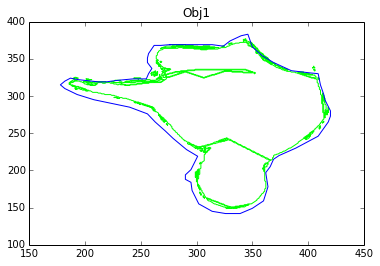

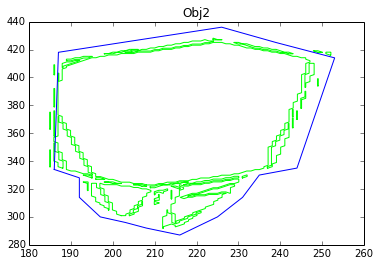

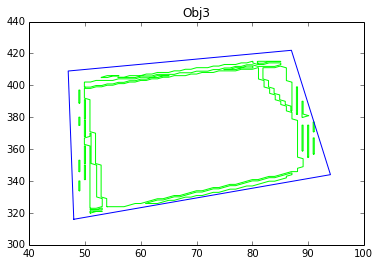

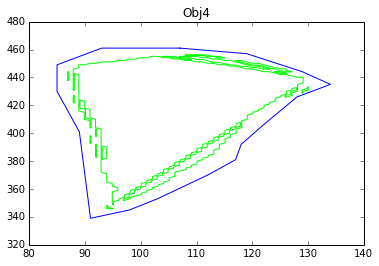

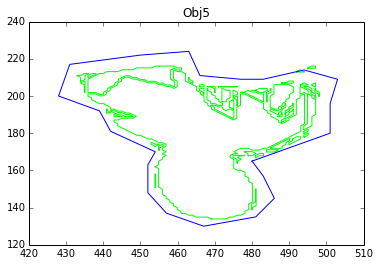

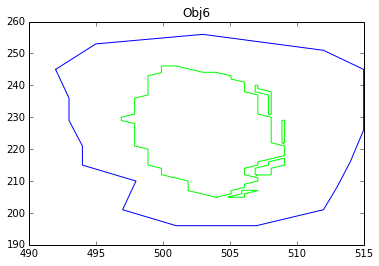

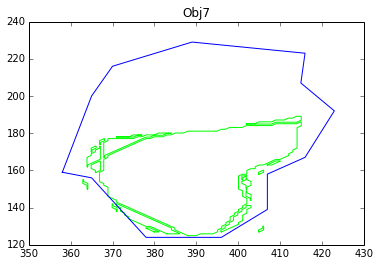

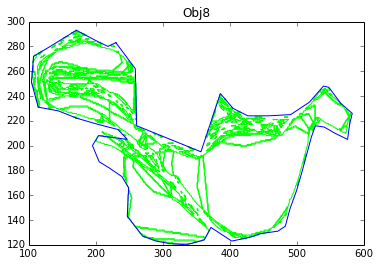

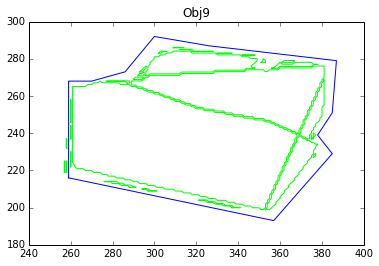

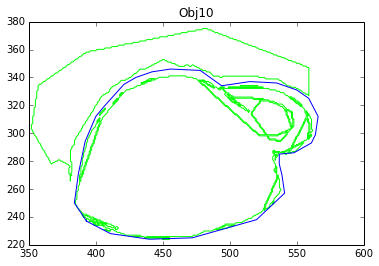

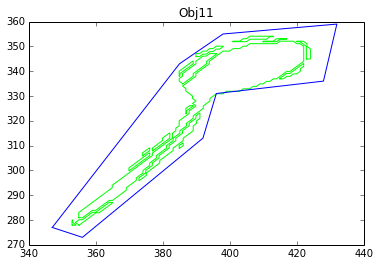

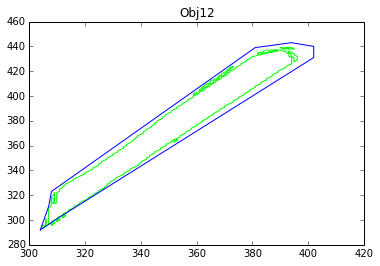

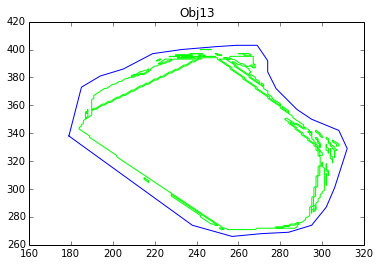

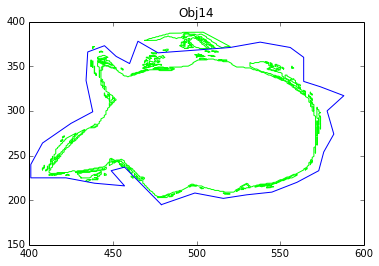

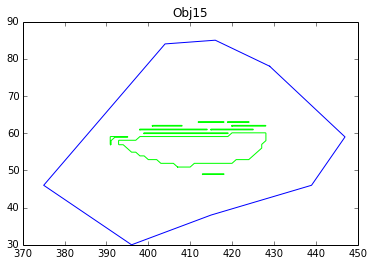

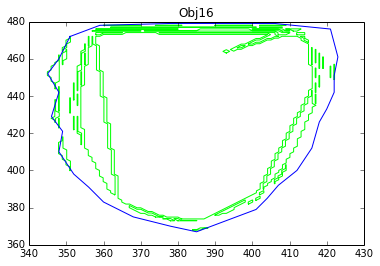

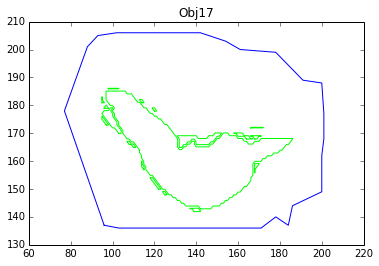

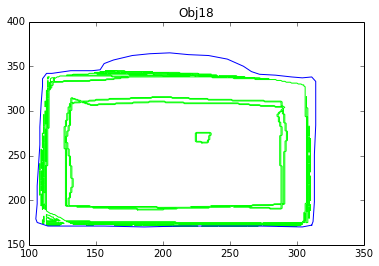

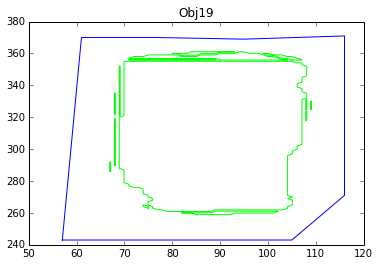

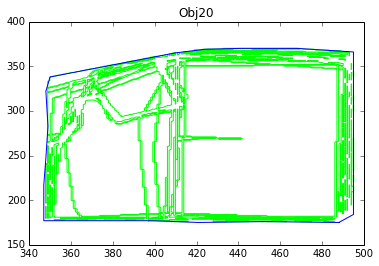

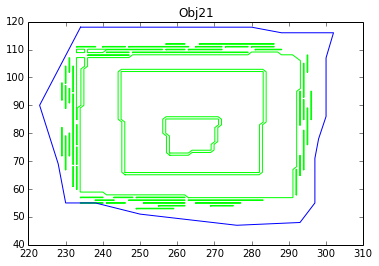

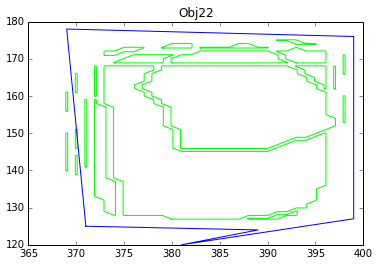

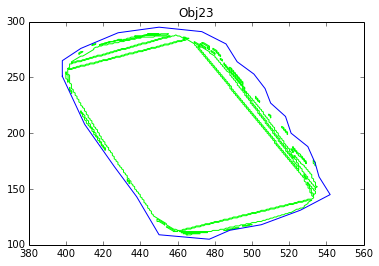

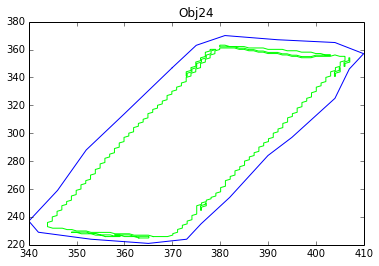

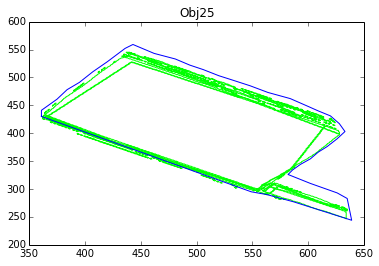

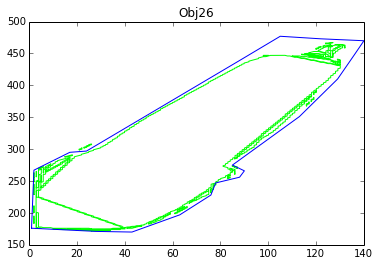

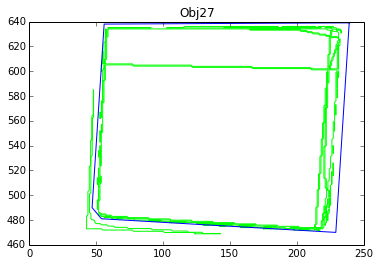

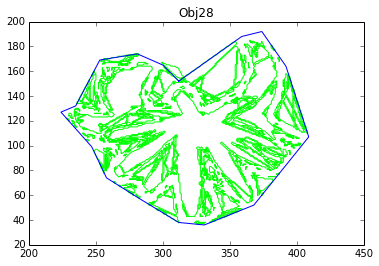

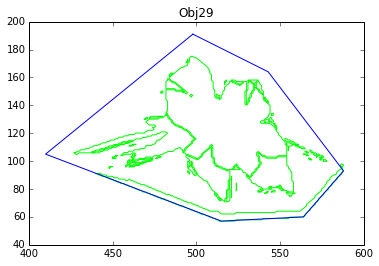

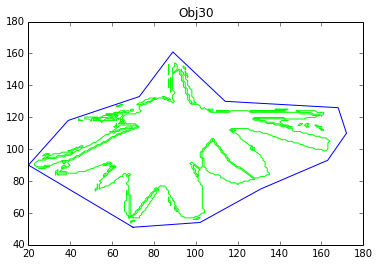

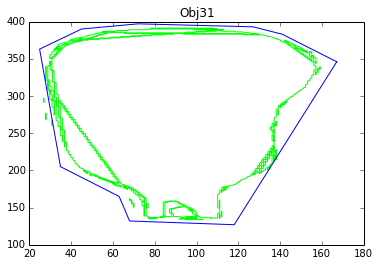

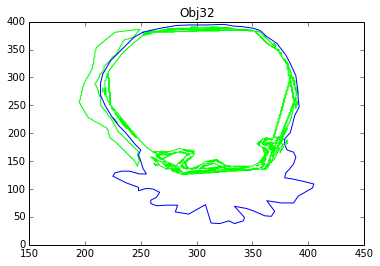

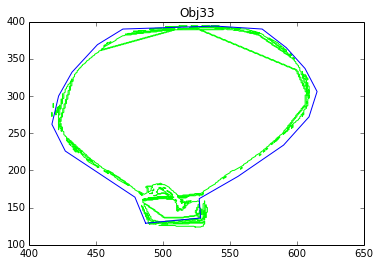

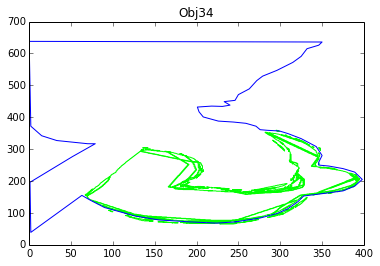

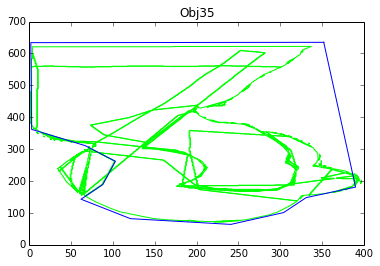

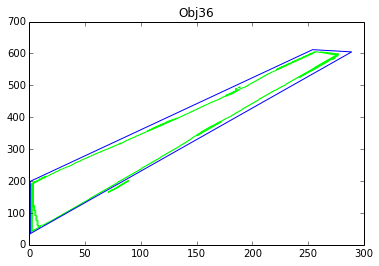

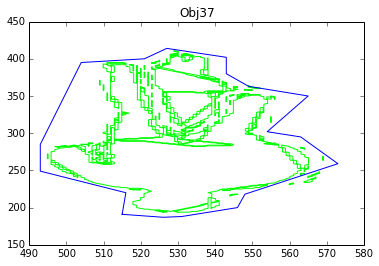

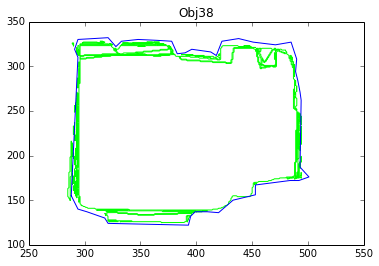

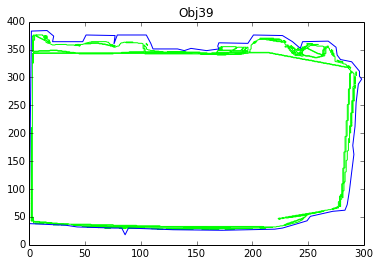

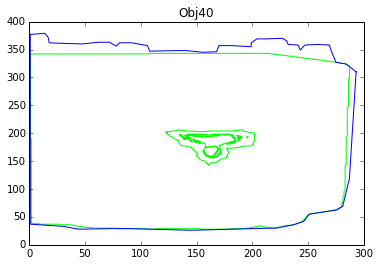

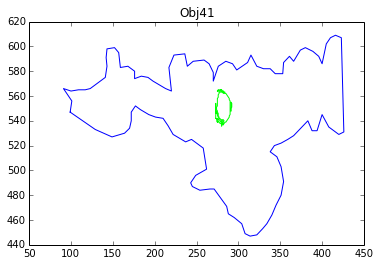

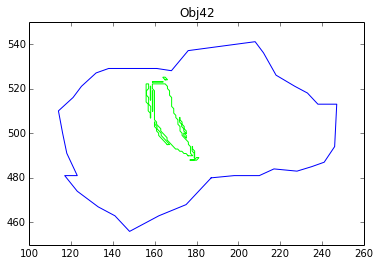

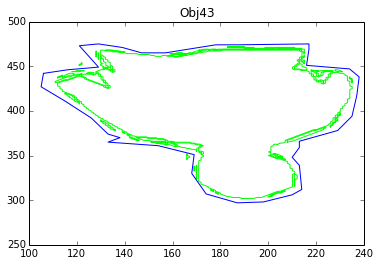

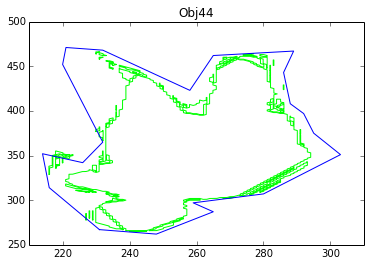

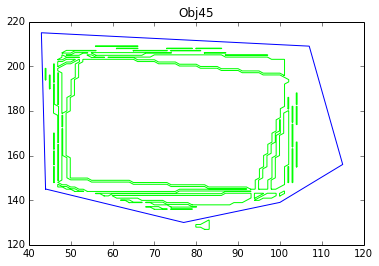

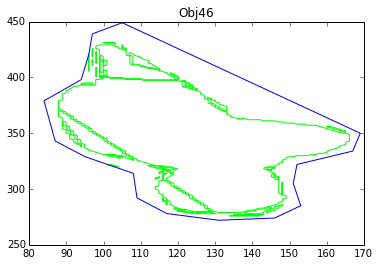

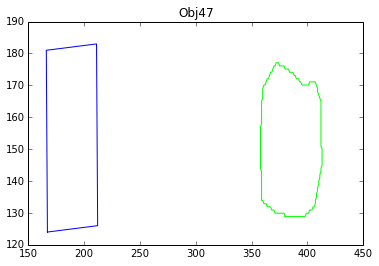

In [6]:
diff_p_lst = []
diff_r_lst = []
for objid in tqdm(object_lst):
    plt.figure()
    plt.title("Obj{}".format(objid))
    diff_p,diff_r=PR_compare(objid)
    diff_p_lst.append(diff_p)
    diff_r_lst.append(diff_r)

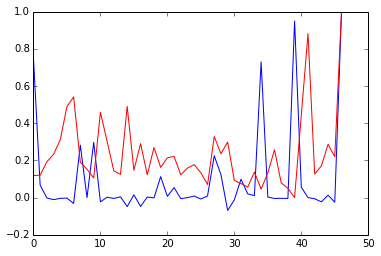

In [7]:
plt.plot(diff_p_lst)
plt.plot(diff_r_lst,color='red')

Removing the tile area<1 constraint and lowering overlap value from 0.7 to 0.4 

  0%|          | 0/47 [00:00<?, ?it/s]

Best worker's PR against BBG:  0.944169228157 0.992825993557
Number of non-overlapping tile regions (M) :  3765
Number of workers (N) :  33
all unvoted tiles: [  4   5   6   7  15  20  25  26  27  33  34  35  36  38  39  41  44  45
  47  51  54  55  59  60  61  62  63  65  66  67  68  69  70  71  72  73
  76  78  80  84  88  91  92  95  99 100 102 104 105 106 107 108 109 110
 111 112 139 160 161 163 164 166 169 170 171 176 178 195 196 212 246 248
 324 329]
all unvoted workers: []
Object  1
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
114
Joined PR:

  2%|▏         | 1/47 [01:14<56:56,  0.01it/s]

 0.19265022006 0.876846175945
Difference:  0.751519008098 0.115979817613
Best worker's PR against BBG:  0.977930266743 1.0
Number of non-overlapping tile regions (M) :  1377
Number of workers (N) :  36
all unvoted tiles: [  1   6   9  11  12  13  15  16  17  18  19  21  23  24  25  26  27  28
  29  31  34  35  36  39  40  41  43  44  46  48  49  57  62  70  71  73
  85  86  87  92 106 148 153]
all unvoted workers: []
Object  2
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
175
Joined PR:

  4%|▍         | 2/47 [01:37<36:35,  0.02it/s]

 0.905754672904 0.88292734103
Difference:  0.0721755938388 0.11707265897
Best worker's PR against BBG:  0.990248040059 0.94648436312
Number of non-overlapping tile regions (M) :  815
Number of workers (N) :  38
all unvoted tiles: [  1   2   3   5   7   9  10  13  14  18  19  21  22  27  32  33  38  53
  54  56  57  60  63  78 100 101 102 106 107]
all unvoted workers: []
Object  3
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
175
Joined PR:

  6%|▋         | 3/47 [01:51<27:12,  0.03it/s]

 0.989711043852 0.759672133494
Difference:  0.000536996206573 0.186812229626
Best worker's PR against BBG:  0.981390012593 0.983619260089
Number of non-overlapping tile regions (M) :  1127
Number of workers (N) :  39
all unvoted tiles: [  0   4   6   7   9  12  13  14  16  17  18  19  20  22  24  27  28  31
  32  33  34  35  37  38  41  42  43  46  47  48  49  50  52  53  54  55
  57  59  60  65  70  75  83  89  90  96  98 109 164 191]
all unvoted workers: []
Object  4
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
232
Joined PR:

  9%|▊         | 4/47 [02:11<23:37,  0.03it/s]

 0.987877651488 0.757449735695
Difference:  -0.00648763889499 0.226169524393
Best worker's PR against BBG:  0.990837224185 0.950324076004
Number of non-overlapping tile regions (M) :  1382
Number of workers (N) :  38
all unvoted tiles: [ 3  6  8  9 11 13 14 16 21 24 26 27 29 32 33 35 37 38 39 41 42 43 44 55 63
 76 89 91 94]
all unvoted workers: []
Object  5
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
238
Joined PR:

 11%|█         | 5/47 [02:39<22:16,  0.03it/s]

 0.991882444416 0.650338712449
Difference:  -0.00104522023162 0.299985363555
Best worker's PR against BBG:  0.996977818327 1.0
Number of non-overlapping tile regions (M) :  417
Number of workers (N) :  39
all unvoted tiles: [ 5  6  8 11 12 13 14 15 18 33 34]
all unvoted workers: []
Object  6
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
109
Joined PR:

 13%|█▎        | 6/47 [02:46<18:57,  0.04it/s]

 0.991373451936 0.519776174333
Difference:  0.00560436639123 0.480223825667
Best worker's PR against BBG:  0.942381337373 0.974135869084
Number of non-overlapping tile regions (M) :  1286
Number of workers (N) :  39
all unvoted tiles: [ 10  11  16  17  22  27  29  61  67 115]
all unvoted workers: []
Object  7
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
133
Joined PR:

 15%|█▍        | 7/47 [03:09<18:03,  0.04it/s]

 0.96696613716 0.4371759623
Difference:  -0.024584799787 0.536959906783
Best worker's PR against BBG:  0.965834097823 0.989920558258
Number of non-overlapping tile regions (M) :  6068
Number of workers (N) :  37
all unvoted tiles: [  2   3   4   5   6   7   8   9  10  12  13  14  16  19  21  22  23  25
  26  28  30  35  40  41  42  44  47  48  49  50  54  56  57  59  63  64
  65  66  68  70  75  76  79  82  84  85  88  89  90  91  93  94  95  97
  98  99 101 105 106 107 109 111 112 113 117 118 119 120 121 122 123 125
 126 143 148 167 195 199 201 202 207 209 237 240 245 287 288 292 293 294
 301 303 304 306 307 311 377 427 429 432 490 509 682 900]
all unvoted workers: []
Object  8
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
247
Joined PR:

 17%|█▋        | 8/47 [05:33<27:06,  0.02it/s]

 0.640837312092 0.807886055717
Difference:  0.324996785731 0.182034502541
Best worker's PR against BBG:  0.999002583262 0.974452641021
Number of non-overlapping tile regions (M) :  1534
Number of workers (N) :  39
all unvoted tiles: [  1   2   3   4   5   6   7   8   9  10  11  15  16  19  20  23  27  29
  30  32  37  42  43  45  47  49  56  65  66  67  68  69  70  71 102 105
 122 128 129 130 146 263]
all unvoted workers: []
Object  9
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
146
Joined PR:

 19%|█▉        | 9/47 [06:02<25:29,  0.02it/s]

 0.997313577435 0.828650698305
Difference:  0.00168900582627 0.145801942716
Best worker's PR against BBG:  1.0 1.0
Number of non-overlapping tile regions (M) :  2411
Number of workers (N) :  41
all unvoted tiles: [ 6  7  8  9 10 15 17 21 22 26 27 28 29 30 33 49 67 69]
all unvoted workers: []
Object  10
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
2
Joined PR:

 21%|██▏       | 10/47 [06:54<25:35,  0.02it/s]

 0.702725381837 0.897197911671
Difference:  0.297274618163 0.102802088329
Best worker's PR against BBG:  0.952480721867 0.974806457062
Number of non-overlapping tile regions (M) :  1327
Number of workers (N) :  40
all unvoted tiles: [  0   1   4   5   7   8  10  11  12  13  14  16  17  24  29  30  35  36
  39  40  41  44  45  47  58  68 124 126 132 135]
all unvoted workers: []
Object  11
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
133
Joined PR:

 23%|██▎       | 11/47 [07:19<23:59,  0.03it/s]

 0.971176901243 0.526675462761
Difference:  -0.0186961793758 0.448130994301
Best worker's PR against BBG:  1.0 1.0
Number of non-overlapping tile regions (M) :  1906
Number of workers (N) :  41
all unvoted tiles: [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  20  21  22
  24  25  26  27  28  29  33  34  35  38  39  40  41  42  43  44  45  46
  47  48  49  50  51  54  65  67  68  69  70  71  76  77  78  79  81  83
  84  86  91  92  93 103 104 116 118 128 202 221 230 232 234 315]
all unvoted workers: []
Object  12
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
2
Joined PR:

 26%|██▌       | 12/47 [07:54<23:03,  0.03it/s]

 0.994669927408 0.70394067055
Difference:  0.00533007259193 0.29605932945
Best worker's PR against BBG:  0.990987676546 0.996616520038
Number of non-overlapping tile regions (M) :  2278
Number of workers (N) :  38
all unvoted tiles: [  0   1   2   3   4   6   7   8   9  11  12  13  14  15  18  21  23  24
  25  26  27  29  32  33  35  36  37  38  39  40  41  42  43  44  45  47
  48  49  50  51  52  53  55  56  58  59  60  61  62  63  68  72  76  77
  78  79  81  82  85  86  87  88  90  91  92  94 101 103 112 113 117 119
 128 130 133 146 153 154 159 163 164 165 169 170 174 270 339 340 504]
all unvoted workers: []
Object  13
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
146
Joined PR:

 28%|██▊       | 13/47 [08:34<22:25,  0.03it/s]

 0.993259693264 0.856723099491
Difference:  -0.00227201671822 0.139893420547
Best worker's PR against BBG:  0.978483309871 0.999429953951
Number of non-overlapping tile regions (M) :  4023
Number of workers (N) :  39
all unvoted tiles: [  2   3   6   7   8  15  16  22  35  38  39  40  46  92 118 123]
all unvoted workers: []
Object  14
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
146
Joined PR:

 30%|██▉       | 14/47 [10:11<24:01,  0.02it/s]

 0.971613234041 0.878328024618
Difference:  0.00687007582982 0.121101929334
Best worker's PR against BBG:  0.942954516257 1.0
Number of non-overlapping tile regions (M) :  467
Number of workers (N) :  41
all unvoted tiles: [ 2  9 12 13 17 18 19 20 21 26 28 31 34 40 42 44 49 64]
all unvoted workers: []
Object  15
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
129
Joined PR:

 32%|███▏      | 15/47 [10:19<22:01,  0.02it/s]

 0.962815366126 0.531733341831
Difference:  -0.0198608498684 0.468266658169
Best worker's PR against BBG:  0.996257177416 0.99733704391
Number of non-overlapping tile regions (M) :  999
Number of workers (N) :  36
all unvoted tiles: [  1   2   4   7  11  12  13  17  19  20  23  33  57  59  61  65 108 111
 128]
all unvoted workers: []
Object  16
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
159
Joined PR:

 34%|███▍      | 16/47 [10:36<20:34,  0.03it/s]

 0.972499524129 0.854454941977
Difference:  0.0237576532875 0.142882101933
Best worker's PR against BBG:  0.946851384528 1.0
Number of non-overlapping tile regions (M) :  1218
Number of workers (N) :  43
all unvoted tiles: []
all unvoted workers: []
Object  17
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True
174
Joined PR:

 36%|███▌      | 17/47 [11:03<19:30,  0.03it/s]

 0.9794284397 0.719901016341
Difference:  -0.0325770551724 0.280098983659
Best worker's PR against BBG:  1.0 0.994172162696
Number of non-overlapping tile regions (M) :  1386
Number of workers (N) :  38
all unvoted tiles: [  0   3   4   5   6   8   9  11  12  13  17  18  22  24  25  26  27  28
  30  31  32  33  34  35  37  38  39  41  43  44  53  56  72  85 140]
all unvoted workers: []
Object  18
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
201
Joined PR:

 38%|███▊      | 18/47 [11:26<18:25,  0.03it/s]

 0.996521793817 0.871944803386
Difference:  0.00347820618308 0.12222735931
Best worker's PR against BBG:  0.994673490937 1.0
Number of non-overlapping tile regions (M) :  920
Number of workers (N) :  41
all unvoted tiles: [6 7]
all unvoted workers: []
Object  19
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: False
174
Joined PR:

 40%|████      | 19/47 [11:43<17:16,  0.03it/s]

 0.992541051815 0.732841626159
Difference:  0.00213243912212 0.267158373841
Best worker's PR against BBG:  1.0 0.994044228099
Number of non-overlapping tile regions (M) :  1408
Number of workers (N) :  40


KeyboardInterrupt: 

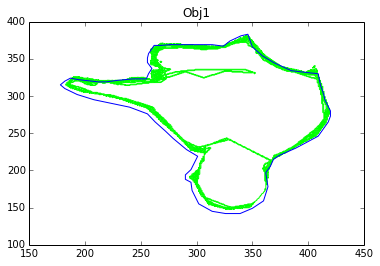

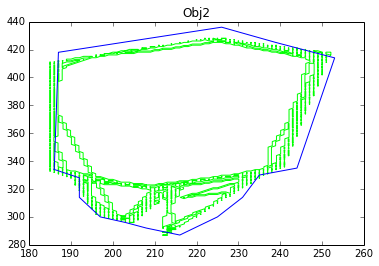

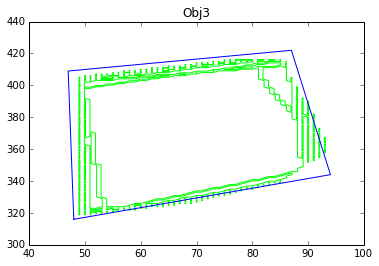

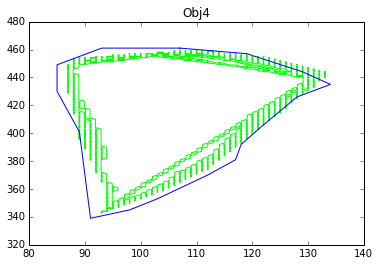

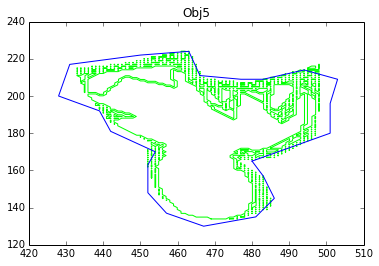

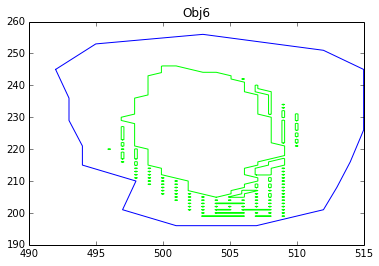

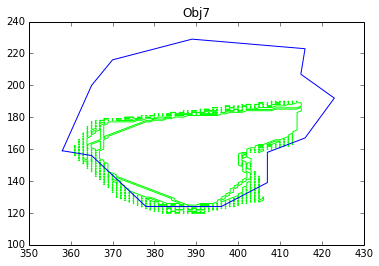

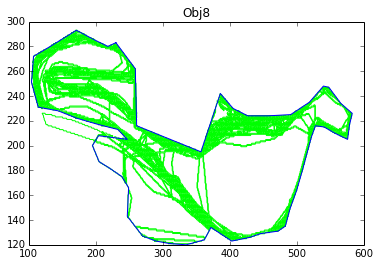

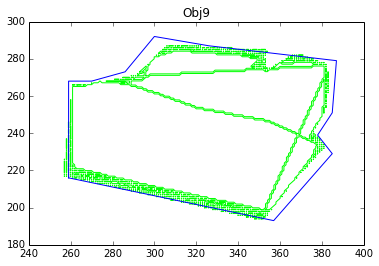

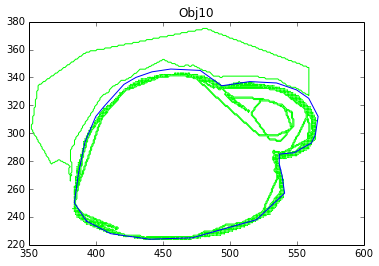

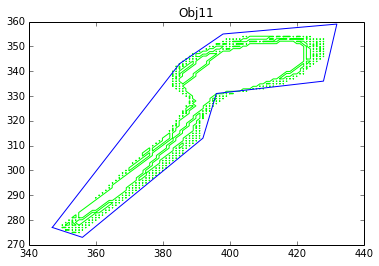

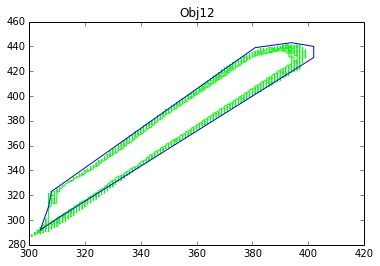

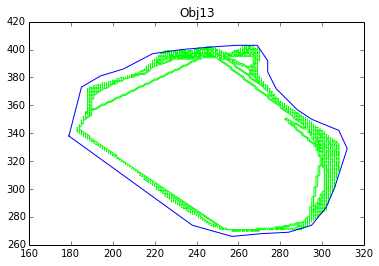

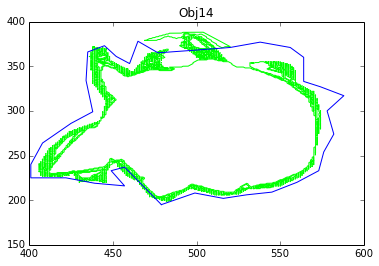

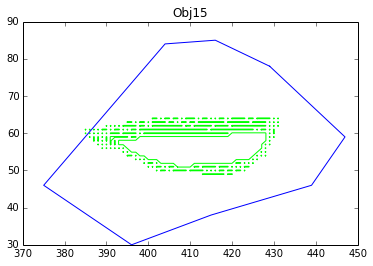

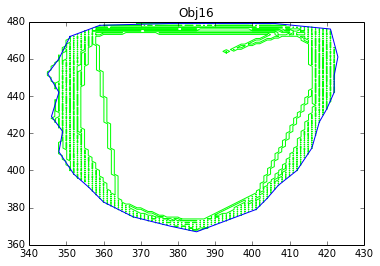

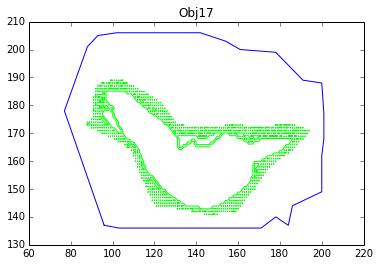

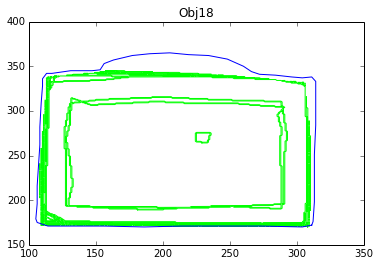

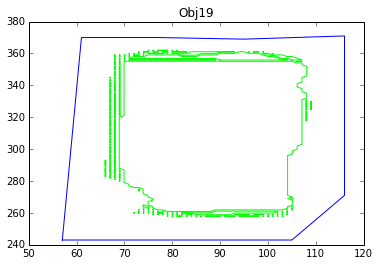

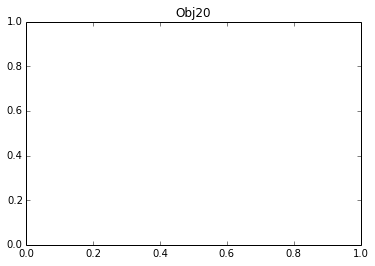

In [6]:
diff_p_lst = []
diff_r_lst = []
for objid in tqdm(object_lst):
    plt.figure()
    plt.title("Obj{}".format(objid))
    diff_p,diff_r=PR_compare(objid)
    diff_p_lst.append(diff_p)
    diff_r_lst.append(diff_r)

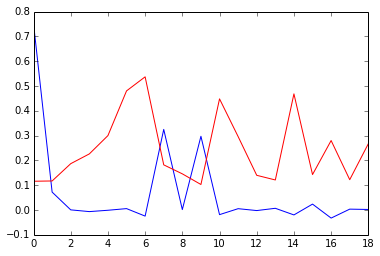

In [7]:
plt.plot(diff_p_lst)
plt.plot(diff_r_lst,color='red')

There is still huge recall losses but the precision is okay

In [8]:
print "Average precision loss" , mean(diff_p_lst)
print "Average recall loss" , mean(diff_r_lst)

Average precision loss 0.0731495295379
Average recall loss 0.246297947934
